In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.tableau import Tableau_10
from scipy import stats as st

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33743/status,
Dashboard: /proxy/33743/status,Workers: 4
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34705,Workers: 4
Dashboard: /proxy/33743/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:46151,Total threads: 4
Dashboard: /proxy/42819/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:41005,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
uas_cmip = {}; vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
model_keys = list(uas_cmip.keys())

Calculate area for weighting

In [6]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [7]:
u_ave = {}
v_ave = {}
for k in keys:
    u_ave[k] = (uas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
for k in model_keys:
    u_ave[k] = (uas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave[k] = (vas_cmip[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [8]:
u_ave_xarray = u_ave[model_keys[0]]
v_ave_xarray = v_ave[model_keys[0]]
for k in model_keys[1:]:
    u_ave_xarray = xr.concat([u_ave_xarray, u_ave[k]], dim = 'model')
    v_ave_xarray = xr.concat([v_ave_xarray, v_ave[k]], dim = 'model')
u_ave_xarray['model'] = model_keys
v_ave_xarray['model'] = model_keys

## SSP85

In [9]:
uas_ssp85 = {}; vas_ssp85 = {}
uas_ssp85['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas']
vas_ssp85['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp8.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp8.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp85[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp85[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [10]:
u_ave_ssp85 = {}
v_ave_ssp85 = {}
for k in ['cmip6']+model_keys:
    u_ave_ssp85[k] = (uas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp85[k] = (vas_ssp85[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [11]:
u_ave_xarray_ssp85 = u_ave_ssp85['cmip6']
v_ave_xarray_ssp85 = v_ave_ssp85['cmip6']
for k in model_keys:
    u_ave_xarray_ssp85 = xr.concat([u_ave_xarray_ssp85, u_ave_ssp85[k]], dim = 'model')
    v_ave_xarray_ssp85 = xr.concat([v_ave_xarray_ssp85, v_ave_ssp85[k]], dim = 'model')
u_ave_xarray_ssp85['model'] = ['cmip6']+model_keys
v_ave_xarray_ssp85['model'] = ['cmip6']+model_keys

In [12]:
u_sd_h = u_ave_xarray.sel(model = model_keys).std('model')
v_sd_h = v_ave_xarray.sel(model = model_keys).std('model')
u_sd_ssp85 = u_ave_xarray_ssp85.sel(model = model_keys).std('model')
v_sd_ssp85 = v_ave_xarray_ssp85.sel(model = model_keys).std('model')

## SSP45

In [13]:
uas_ssp45 = {}; vas_ssp45 = {}
uas_ssp45['cmip6'] = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas']
vas_ssp45['cmip6'] = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas']
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp4.5*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp4.5*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    uas_ssp45[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][3:]
    vas_ssp45[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('2015-01-01', '2100-01-01'))

In [14]:
u_ave_ssp45 = {}
v_ave_ssp45 = {}
for k in ['cmip6']+model_keys:
    u_ave_ssp45[k] = (uas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_ssp45[k] = (vas_ssp45[k].groupby('time.year').mean('time')*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [15]:
u_ave_xarray_ssp45 = u_ave_ssp45['cmip6']
v_ave_xarray_ssp45 = v_ave_ssp45['cmip6']
for k in model_keys:
    u_ave_xarray_ssp45 = xr.concat([u_ave_xarray_ssp45, u_ave_ssp45[k]], dim = 'model')
    v_ave_xarray_ssp45 = xr.concat([v_ave_xarray_ssp45, v_ave_ssp45[k]], dim = 'model')
u_ave_xarray_ssp45['model'] = ['cmip6']+model_keys
v_ave_xarray_ssp45['model'] = ['cmip6']+model_keys

In [16]:
u_sd_h = u_ave_xarray.sel(model = model_keys).std('model')
v_sd_h = v_ave_xarray.sel(model = model_keys).std('model')
u_sd_ssp45 = u_ave_xarray_ssp45.sel(model = model_keys).std('model')
v_sd_ssp45 = v_ave_xarray_ssp45.sel(model = model_keys).std('model')

## Quantify trends

In [17]:
MK_class = Mann_Kendall_test(-u_ave_xarray, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_hist = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_hist = MK_class.compute()

In [18]:
MK_class = Mann_Kendall_test(-u_ave_xarray_ssp85, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_ssp85 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_ssp85, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_ssp85 = MK_class.compute()

In [19]:
MK_class = Mann_Kendall_test(-u_ave_xarray_ssp45, 'time', coords_name = {'year':'time', 'model':'x'})
ut_cmip_ssp45 = MK_class.compute()

MK_class = Mann_Kendall_test(v_ave_xarray_ssp45, 'time', coords_name = {'year':'time', 'model':'x'})
vt_cmip_ssp45 = MK_class.compute()

In [20]:
u_re_concat = u_ave['cmip6']
v_re_concat = v_ave['cmip6']
for k in keys[:-1]:
    u_re_concat = xr.concat([u_re_concat, u_ave[k]], dim = 'model')
    v_re_concat = xr.concat([v_re_concat, v_ave[k]], dim = 'model')
u_re_concat['model'] = ['cmip6']+keys[:-1]
v_re_concat['model'] = ['cmip6']+keys[:-1]

MK_class = Mann_Kendall_test(-u_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
ut_re = MK_class.compute()
MK_class = Mann_Kendall_test(v_re_concat, 'time', coords_name = {'year':'time', 'model':'x'})
vt_re = MK_class.compute()

## Plot

In [38]:
keys

['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [29]:
legend_elements = [Line2D([0], [0], color = 'k', lw = 3, label = 'CMIP6 MMM historical period'),
                   Line2D([0], [0], color = cmocean.cm.balance(.2), lw = 3, label = 'CMIP6 MMM SSP5-8.5'),
                   Line2D([0], [0], color = cmocean.cm.balance(.8), lw = 3, label = 'CMIP6 MMM SSP2-4.5'),
                   Line2D([0], [0], color = 'm', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

In [31]:
cmap = plt.get_cmap('RdBu_r')(.2)

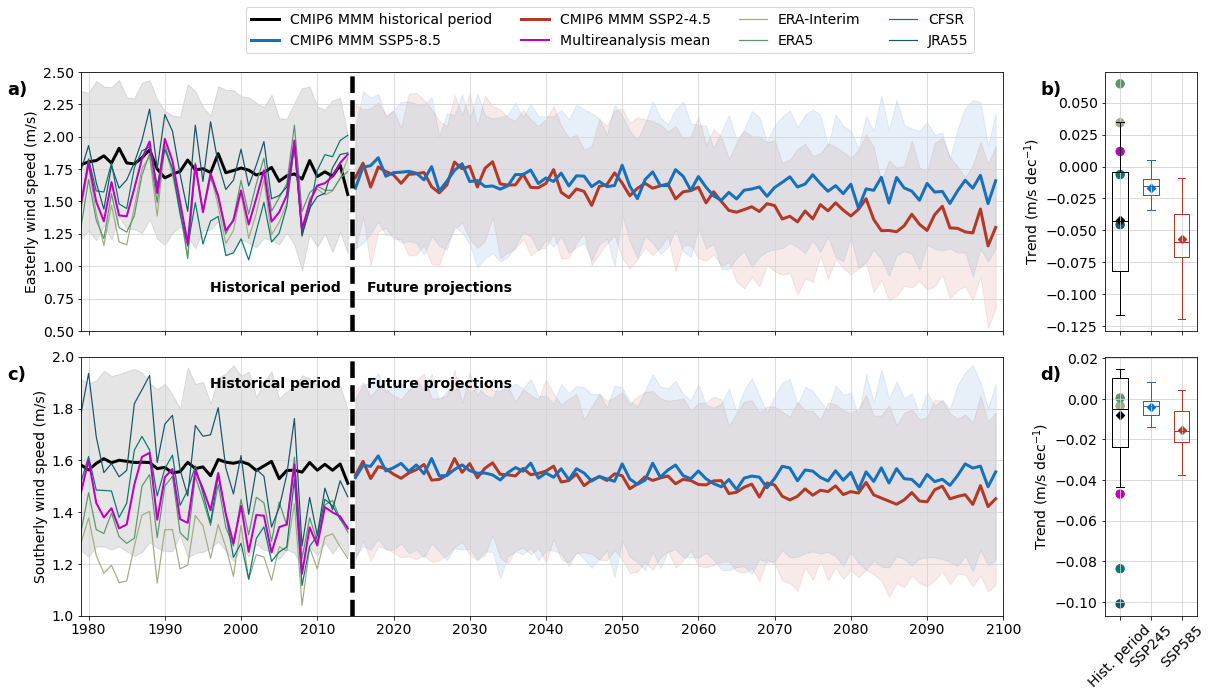

In [34]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, hspace = 0.1, width_ratios = [1, .1])
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['a)', 'c)', 'b)', 'd)']):
    ax.grid(linestyle = '-', color = 'lightgrey')
    if ax in axs[:2]:
        ax.text(-0.08, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xticks(np.arange(1980, 2110, 10))
        ax.set_xlim(1979, 2100)
    else:
        ax.text(-0.7, .91, label, transform = ax.transAxes, size = 18, weight = 'bold')
        ax.set_xlim(-.5, 2.5)

        
axs[0].plot(u_ave['cmip6']['year'], -u_ave['cmip6'], color = 'k', linewidth = 3)
axs[0].fill_between(u_ave['cmip6']['year'], -u_ave['cmip6']+u_sd_h, -u_ave['cmip6']-u_sd_h, 
                    color = 'k', alpha = 0.1)
axs[1].plot(v_ave['cmip6']['year'], v_ave['cmip6'], color = 'k', linewidth = 3)
axs[1].fill_between(v_ave['cmip6']['year'], v_ave['cmip6']-v_sd_h, v_ave['cmip6']+v_sd_h, 
                    color = 'k', alpha = 0.1)

for k, cl in zip(keys[:-2], [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76)]):
    axs[0].plot(u_ave[k]['year'], -u_ave[k], color = cl, linewidth = 1.2, label = k)
    axs[1].plot(v_ave[k]['year'], v_ave[k], color = cl, linewidth = 1.2, label = k)
    
axs[0].plot(u_ave['reanalysis']['year'], -u_ave['reanalysis'], color = 'm', linewidth = 2)
axs[0].plot(u_ave_ssp85['cmip6']['year'], -u_ave_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[0].fill_between(u_ave_ssp85['cmip6']['year'],-u_ave_ssp85['cmip6']+u_sd_ssp85, 
                    -u_ave_ssp85['cmip6']-u_sd_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[0].plot(u_ave_ssp45['cmip6']['year'], -u_ave_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[0].fill_between(u_ave_ssp45['cmip6']['year'],
                    -u_ave_ssp45['cmip6']+u_sd_ssp45, -u_ave_ssp45['cmip6']-u_sd_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[1].plot(v_ave['reanalysis']['year'], v_ave['reanalysis'], color = 'm', linewidth = 2)
axs[1].plot(v_ave_ssp85['cmip6']['year'], v_ave_ssp85['cmip6'], color = cmocean.cm.balance(.8), linewidth = 3)
axs[1].fill_between(v_ave_ssp85['cmip6']['year'],v_ave_ssp85['cmip6']-v_sd_ssp85, 
                    v_ave_ssp85['cmip6']+v_sd_ssp85, 
                    color = cmocean.cm.balance(.8), alpha = 0.1)
axs[1].plot(v_ave_ssp45['cmip6']['year'], v_ave_ssp45['cmip6'], color = cmocean.cm.balance(.2), linewidth = 3)
axs[1].fill_between(v_ave_ssp45['cmip6']['year'],
                    v_ave_ssp45['cmip6']-v_sd_ssp45, v_ave_ssp45['cmip6']+v_sd_ssp45, 
                    color = cmocean.cm.balance(.2), alpha = 0.1)

axs[0].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
axs[1].axvline(x = 2015-.5, linewidth = 4.5, linestyle = '--', color = 'k')
axs[0].set_ylim(0.5, 2.5)
axs[1].set_ylim(1, 2)
axs[0].set_xticklabels([])
axs[0].set_ylabel('Easterly wind speed (m/s)')
axs[1].set_ylabel('Southerly wind speed (m/s)')
axs[0].text(0.14, .15, 'Historical period', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[0].text(0.31, .15, 'Future projections', transform = axs[0].transAxes, size = 14, weight = 'bold')
axs[1].text(0.14, .88, 'Historical period', transform = axs[1].transAxes, size = 14, weight = 'bold')
axs[1].text(0.31, .88, 'Future projections', transform = axs[1].transAxes, size = 14, weight = 'bold')

axs[2].boxplot(ut_cmip_hist['trend']*10, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[2].boxplot(ut_cmip_ssp45.drop_sel(x = 'cmip6')['trend']*10, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[2].boxplot(ut_cmip_ssp85.drop_sel(x = 'cmip6')['trend']*10, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[2].scatter(np.zeros(5), ut_re['trend'].drop_sel(x = 'cmip6')*10, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[2].scatter(0, ut_re['trend'].sel(x = 'cmip6')*10, c = 'k', marker = 'D')
axs[2].scatter(1, ut_cmip_ssp45['trend'].sel(x = 'cmip6')*10, marker = 'D', color = cmocean.cm.balance(.2))
axs[2].scatter(2, ut_cmip_ssp85['trend'].sel(x = 'cmip6')*10, marker = 'D', color = cmocean.cm.balance(.8))

axs[3].boxplot(vt_cmip_hist['trend']*10, positions = [0], widths = .5,
               showfliers = False, medianprops=dict(color='k'))
axs[3].boxplot(vt_cmip_ssp45.drop_sel(x = 'cmip6')['trend']*10, positions = [1], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.2)), boxprops=dict(c = cmocean.cm.balance(.2)), capprops=dict(c=cmocean.cm.balance(.2)),
               whiskerprops=dict(c=cmocean.cm.balance(.2)))
axs[3].boxplot(vt_cmip_ssp85.drop_sel(x = 'cmip6')['trend']*10, positions = [2], widths = .5,
               showfliers = False, medianprops=dict(c=cmocean.cm.balance(.8)), boxprops=dict(c = cmocean.cm.balance(.8)), capprops=dict(c=cmocean.cm.balance(.8)),
               whiskerprops=dict(c=cmocean.cm.balance(.8))) 
axs[3].scatter(np.zeros(5), vt_re['trend'].drop_sel(x = 'cmip6')*10, s = 70,
               c = [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm'],
               marker = 'o', zorder = 0)
axs[3].scatter(0, vt_re['trend'].sel(x = 'cmip6')*10, c = 'k', marker = 'D')
axs[3].scatter(1, vt_cmip_ssp45['trend'].sel(x = 'cmip6')*10, marker = 'D', color = cmocean.cm.balance(.2))
axs[3].scatter(2, vt_cmip_ssp85['trend'].sel(x = 'cmip6')*10, marker = 'D', color = cmocean.cm.balance(.8))

axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels([])
axs[3].set_xticks([0,1,2])
axs[3].set_xticklabels(['Hist. period', 'SSP245', 'SSP585'], rotation = 45)
axs[2].set_ylabel('Trend (m/s dec$^{-1}$)')
axs[3].set_ylabel('Trend (m/s dec$^{-1}$)')

fig.legend(handles = legend_elements, ncol = 4, bbox_to_anchor = (0.75, .98))

plt.savefig('../results/v6/fig4.jpg', bbox_inches = 'tight')

In [49]:
print(ut_re['trend']*10)

<xarray.DataArray 'trend' (x: 6)>
array([-0.04155385,  0.03430658,  0.06480676, -0.00629812, -0.04548379,
        0.01183286])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [125]:
print(vt_re['trend']*10)

<xarray.DataArray 'trend' (x: 6)>
array([-0.00812981, -0.00338158,  0.0004127 , -0.08368424, -0.10099896,
       -0.04691302])
Coordinates:
  * x        (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'


In [127]:
print(ut_cmip_ssp45['trend'].sel(x='cmip6')*10)

<xarray.DataArray 'trend' ()>
array(-0.01710701)
Coordinates:
    x        <U16 'cmip6'


In [128]:
print(vt_cmip_ssp45['trend'].sel(x='cmip6')*10)

<xarray.DataArray 'trend' ()>
array(-0.00418277)
Coordinates:
    x        <U16 'cmip6'


In [129]:
print(ut_cmip_ssp85['trend'].sel(x='cmip6')*10)

<xarray.DataArray 'trend' ()>
array(-0.05633116)
Coordinates:
    x        <U16 'cmip6'


In [130]:
print(vt_cmip_ssp85['trend'].sel(x='cmip6')*10)

<xarray.DataArray 'trend' ()>
array(-0.01516327)
Coordinates:
    x        <U16 'cmip6'


In [23]:
u_ave['cmip6'].sel(year = slice(2005,2015)).mean('year')

<xarray.DataArray ()>
array(-1.70080107)
Coordinates:
    height   float64 10.0

In [24]:
v_ave['cmip6'].sel(year = slice(2005,2015)).mean('year')

<xarray.DataArray ()>
array(1.5602804)
Coordinates:
    height   float64 ...

In [26]:
(1.7-0.595)*100/1.7

65.0

In [28]:
0.002*85

0.17

In [29]:
(1.7-0.17)*100/1.7

90.0

In [31]:
ut_cmip_ssp45

<xarray.Dataset>
Dimensions:    (x: 20)
Coordinates:
  * x          (x) <U16 'cmip6' 'INM-CM4-8' ... 'FGOALS-f3-L' 'CanESM5'
Data variables:
    trend      (x) float64 -0.001711 -0.0001889 ... -0.00654 -0.002506
    signif     (x) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 1.0 0.0
    p          (x) float64 3.179e-07 0.8644 0.5462 ... 0.1636 0.0002026 0.0423
    std_error  (x) float64 0.0007603 0.003417 0.003555 ... 0.004145 0.00292

In [32]:
vt_cmip_ssp45

<xarray.Dataset>
Dimensions:    (x: 20)
Coordinates:
  * x          (x) <U16 'cmip6' 'INM-CM4-8' ... 'FGOALS-f3-L' 'CanESM5'
Data variables:
    trend      (x) float64 -0.0004183 -0.0001661 ... -0.001389 -0.001058
    signif     (x) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 1.0 0.0 0.0 0.0
    p          (x) float64 0.0007202 0.6137 0.7701 ... 0.0679 0.02798 0.03451
    std_error  (x) float64 0.000303 0.0008262 0.001755 ... 0.001456 0.001286

In [33]:
ut_cmip_ssp85

<xarray.Dataset>
Dimensions:    (x: 20)
Coordinates:
  * x          (x) <U16 'cmip6' 'INM-CM4-8' ... 'FGOALS-f3-L' 'CanESM5'
Data variables:
    trend      (x) float64 -0.005633 -0.002327 -0.001014 ... -0.01194 -0.006502
    signif     (x) float64 1.0 0.0 0.0 1.0 1.0 1.0 ... 1.0 0.0 1.0 1.0 1.0 1.0
    p          (x) float64 0.0 0.1378 0.619 ... 4.147e-08 4.277e-10 1.275e-08
    std_error  (x) float64 0.0008387 0.00324 0.003409 ... 0.004107 0.002564

In [34]:
vt_cmip_ssp85

<xarray.Dataset>
Dimensions:    (x: 20)
Coordinates:
  * x          (x) <U16 'cmip6' 'INM-CM4-8' ... 'FGOALS-f3-L' 'CanESM5'
Data variables:
    trend      (x) float64 -0.001516 -0.0005738 ... -0.003733 -0.001774
    signif     (x) float64 1.0 0.0 0.0 1.0 0.0 0.0 ... 1.0 0.0 1.0 1.0 1.0 1.0
    p          (x) float64 0.0 0.1118 0.4321 ... 1.904e-06 1.016e-09 0.0003348
    std_error  (x) float64 0.0002666 0.0007554 0.001774 ... 0.001297 0.001284

In [39]:
ut_re

<xarray.Dataset>
Dimensions:    (x: 6)
Coordinates:
  * x          (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'
Data variables:
    trend      (x) float64 -0.004155 0.003431 0.006481 ... -0.004548 0.001183
    signif     (x) float64 1.0 0.0 0.0 0.0 0.0 0.0
    p          (x) float64 0.0002231 0.2583 0.05832 0.8381 0.2583 0.6336
    std_error  (x) float64 0.001549 0.00638 0.005735 0.007971 0.006062 0.005844

In [40]:
vt_re

<xarray.Dataset>
Dimensions:    (x: 6)
Coordinates:
  * x          (x) <U10 'cmip6' 'erai' 'era5' 'cfsr' 'jra55' 'reanalysis'
Data variables:
    trend      (x) float64 -0.000813 -0.0003382 4.127e-05 ... -0.0101 -0.004691
    signif     (x) float64 0.0 0.0 0.0 1.0 1.0 1.0
    p          (x) float64 0.03475 0.924 0.8381 0.0002483 0.0001295 0.009279
    std_error  (x) float64 0.0005413 0.002584 0.00265 0.003201 0.003665 0.002782